# Comparison of the updated population density (2020) of the neighborhood councils of the LA city.

### The population of the neighborhood councils have been computed using the latest census 2020 data by 2 methods-
#### - 1) Geospatial analysis using arcGIS software$^{a}$ 
#### - 2) Geospatial analysis using Geopandas

#### a. The Geospatial analysis using arcGIS software was executed by Piero at the NC blocks level. 
#### This notebook is going to compare the results from these two methods and find the percentage difference between the two. 

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Path to the directory.
DIR = pwd

# Loading the files of interest.
nc_pop_geopandas = pd.read_csv(os.path.join(DIR, "tracts_nc_final.csv"), index_col=0)
nc_pop_arcgis = pd.read_csv(os.path.join(DIR, "NC_pop_2020_arcGIS.csv"))

In [3]:
# Cleaning up the NC_pop_geopandas to follow the same naming convention as NC_pop_arcGIS.
nc_pop_geopandas["NAME"] = nc_pop_geopandas["NAME"].str.replace(" NC", "")
nc_pop_geopandas["NAME"] = nc_pop_geopandas["NAME"].str.replace("NC ", "")
nc_pop_geopandas["NAME"] = nc_pop_geopandas["NAME"].str.replace(" NDC", "")
nc_pop_geopandas["NAME"] = nc_pop_geopandas["NAME"].str.replace(" CC", "")

In [4]:
# Creating a dictionary, mapping the old names to the new ones.
dictionary = {
    "COMMUNITY AND NEIGHBORS FOR NINTH DISTRICT UNITY": "CANNDU",
    "WEST LOS ANGELES SAWTELLE": "WEST LOS ANGELES",
    "UNITED NEIGHBORHOODS": "UNNC",
    "COMMUNITY AND NEIGHBORS FOR NINTH DISTRICT UNITY (CANNDU)": "CANNDU (CANNDU)",
    "EMPOWERMENT CONGRESS CENTRAL AREA": "EMPOWERMENT CONGRESS CENTRAL",
    "EMPOWERMENT CONGRESS NORTH AREA": "EMPOWERMENT CONGRESS NORTH",
    "EMPOWERMENT CONGRESS SOUTHWEST AREA": "EMPOWERMENT CONGRESS SOUTHWEST",
    "EMPOWERMENT CONGRESS SOUTHEAST AREA": "EMPOWERMENT CONGRESS SOUTHEAST",
    "EMPOWERMENT CONGRESS WEST AREA": "EMPOWERMENT CONGRESS WEST",
    "NORTH HOLLYWOOD NORTH EAST": "NORTH HOLLYWOOD NORTHEAST",
    "ZAPATA-KING": "ZAPATA KING",
    "UNITED NEIGHBORHOODS": "UNNC",
}

def convert(name, dictionary):
    """ The function replaces the old names with the new names.  
    """
    rep = name
    for key, value in dictionary.items():
        if name in dictionary:
            rep = rep.replace(key, value)
        else:
            return name
    return rep

nc_pop_geopandas["NAME"] = nc_pop_geopandas["NAME"].apply(
    lambda row: convert(row, dictionary)
)
nc_pop_geopandas.sort_values(by="NAME", inplace=True, ignore_index=True)

In [5]:
# Since we have to merge the above files on the column- neighborhood council (NC) name,
# (the arcGIS file does not have NC_ID), # let us make sure the same naming convention
# is followed. Rename the columns in nc_pop_arcgis.
nc_pop_arcgis.rename(
    columns={
        "council_name": "NAME",
        "sum_pop20": "pop_arcgis",
        "area_sqmi": "area_arcgis",
        "pop_density": "pop_den_arcgis",
    },
    inplace=True,
)
nc_pop_arcgis["pop_arcgis"] = nc_pop_arcgis["pop_arcgis"].astype(float)
nc_pop_arcgis["NAME"] = nc_pop_arcgis["NAME"].apply(str.upper)
nc_pop_arcgis["NAME"] = nc_pop_arcgis["NAME"].str.replace("CANNDU", "CANNDU (CANNDU)")
nc_pop_arcgis.head()

,NAME,pop_arcgis,area_arcgis,pop_den_arcgis
0,ARLETA,33954.0,3.276005,10364.452920
1,ARROYO SECO,18922.0,3.069553,6164.414787
2,ATWATER VILLAGE,13988.0,8.773863,1594.280640
3,BEL AIR-BEVERLY CREST,26194.0,16.984129,1542.263356
4,BOYLE HEIGHTS,81118.0,5.734130,14146.523600


In [6]:
nc_pop_arcgis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NAME            99 non-null     object 
 1   pop_arcgis      99 non-null     float64
 2   area_arcgis     99 non-null     float64
 3   pop_den_arcgis  99 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.2+ KB


In [7]:
nc_pop_geopandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NAME              99 non-null     object 
 1   NC_ID             99 non-null     int64  
 2   total_population  99 non-null     int64  
 3   area              99 non-null     float64
 4   pop_density       99 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 4.0+ KB


In [8]:
# Merge the two dataframes on the column- 'NAME'.
pop_compare = pd.merge(nc_pop_geopandas, nc_pop_arcgis, on="NAME")
pop_compare.sort_values(by="NAME", inplace=True, ignore_index=True)
pop_compare.head()

,NAME,NC_ID,total_population,area,pop_density,pop_arcgis,area_arcgis,pop_den_arcgis
0,ARLETA,6,35585,3.284868,10833.007723,33954.0,3.276005,10364.452920
1,ARROYO SECO,42,19479,3.063327,6358.773341,18922.0,3.069553,6164.414787
2,ARTS DISTRICT LITTLE TOKYO,46,4153,0.879216,4723.528997,8933.0,0.882223,10125.559200
3,ATWATER VILLAGE,37,14665,8.748450,1676.296980,13988.0,8.773863,1594.280640
4,BEL AIR-BEVERLY CREST,64,24732,17.038756,1451.514436,26194.0,16.984129,1542.263356


In [9]:
# Adding the population difference column.
pop_compare["pop_diff_percent"] = (
    abs(pop_compare["total_population"] - pop_compare["pop_arcgis"])
    / ((pop_compare["total_population"] + pop_compare["pop_arcgis"]) / 2)
) * 100
pop_diff = pop_compare[
    ["NAME", "NC_ID", "total_population", "pop_arcgis", "pop_diff_percent"]
]

In [10]:
# Printing the maximum population difference value. 
pop_diff.iloc[pop_diff["pop_diff_percent"].argmax()]

NAME                ARTS DISTRICT LITTLE TOKYO
NC_ID                                       46
total_population                          4153
pop_arcgis                              8933.0
pop_diff_percent                     73.055173
Name: 2, dtype: object

In [11]:
# Number of rows with population difference greater than 10%.
pop_diff[pop_diff["pop_diff_percent"] > 10].nunique()

NAME                13
NC_ID               13
total_population    13
pop_arcgis          13
pop_diff_percent    13
dtype: int64

In [12]:
# Number of NCs with pop_diff lesser than or equal to 10%.
pop_diff[pop_diff["pop_diff_percent"] <= 10].nunique()

NAME                86
NC_ID               86
total_population    86
pop_arcgis          86
pop_diff_percent    86
dtype: int64

In [13]:
# Population difference greater than 10%.
pop_diff_gt_10_perc = pop_diff[pop_diff["pop_diff_percent"] > 10]

# Population difference less than or equal to 10%.
pop_diff_lte_10_perc = pop_diff[pop_diff["pop_diff_percent"] <= 10]

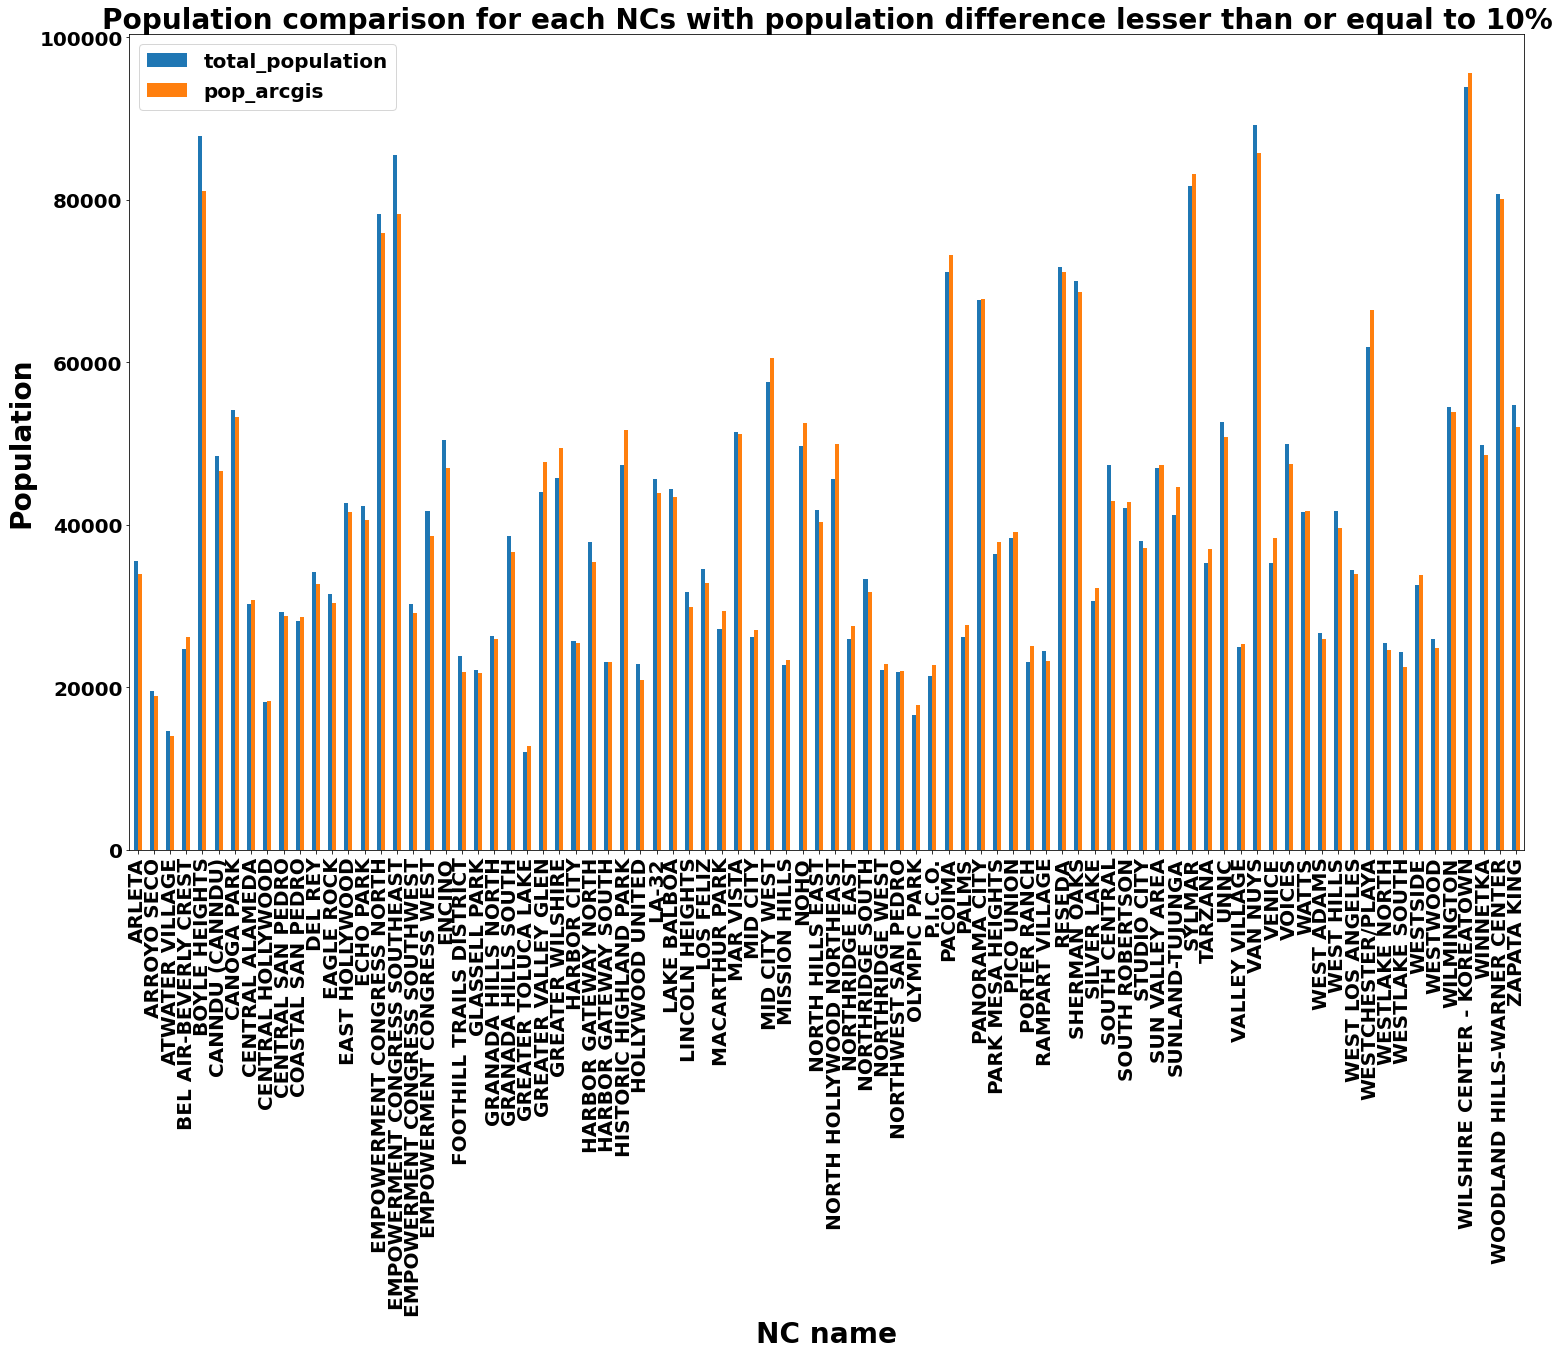

In [14]:
# Population difference lesser than or equal to 10%.
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
fig, ax = plt.subplots(figsize=(25, 15))
# 'gca' stands for get current axis.
ax = plt.gca()
pop_diff_lte_10_perc.plot(
    kind="bar", x="NAME", y=["total_population", "pop_arcgis"], ax=ax
)
plt.title(
    "Population comparison for each NCs with population difference lesser than or equal to 10%",
    size=28,
    fontweight="bold",
)
plt.xlabel("NC name", size=28)
plt.ylabel("Population", size=28)
ax.tick_params(axis="both", labelsize=20)
ax.legend(loc="upper left", fontsize=20)
plt.show()

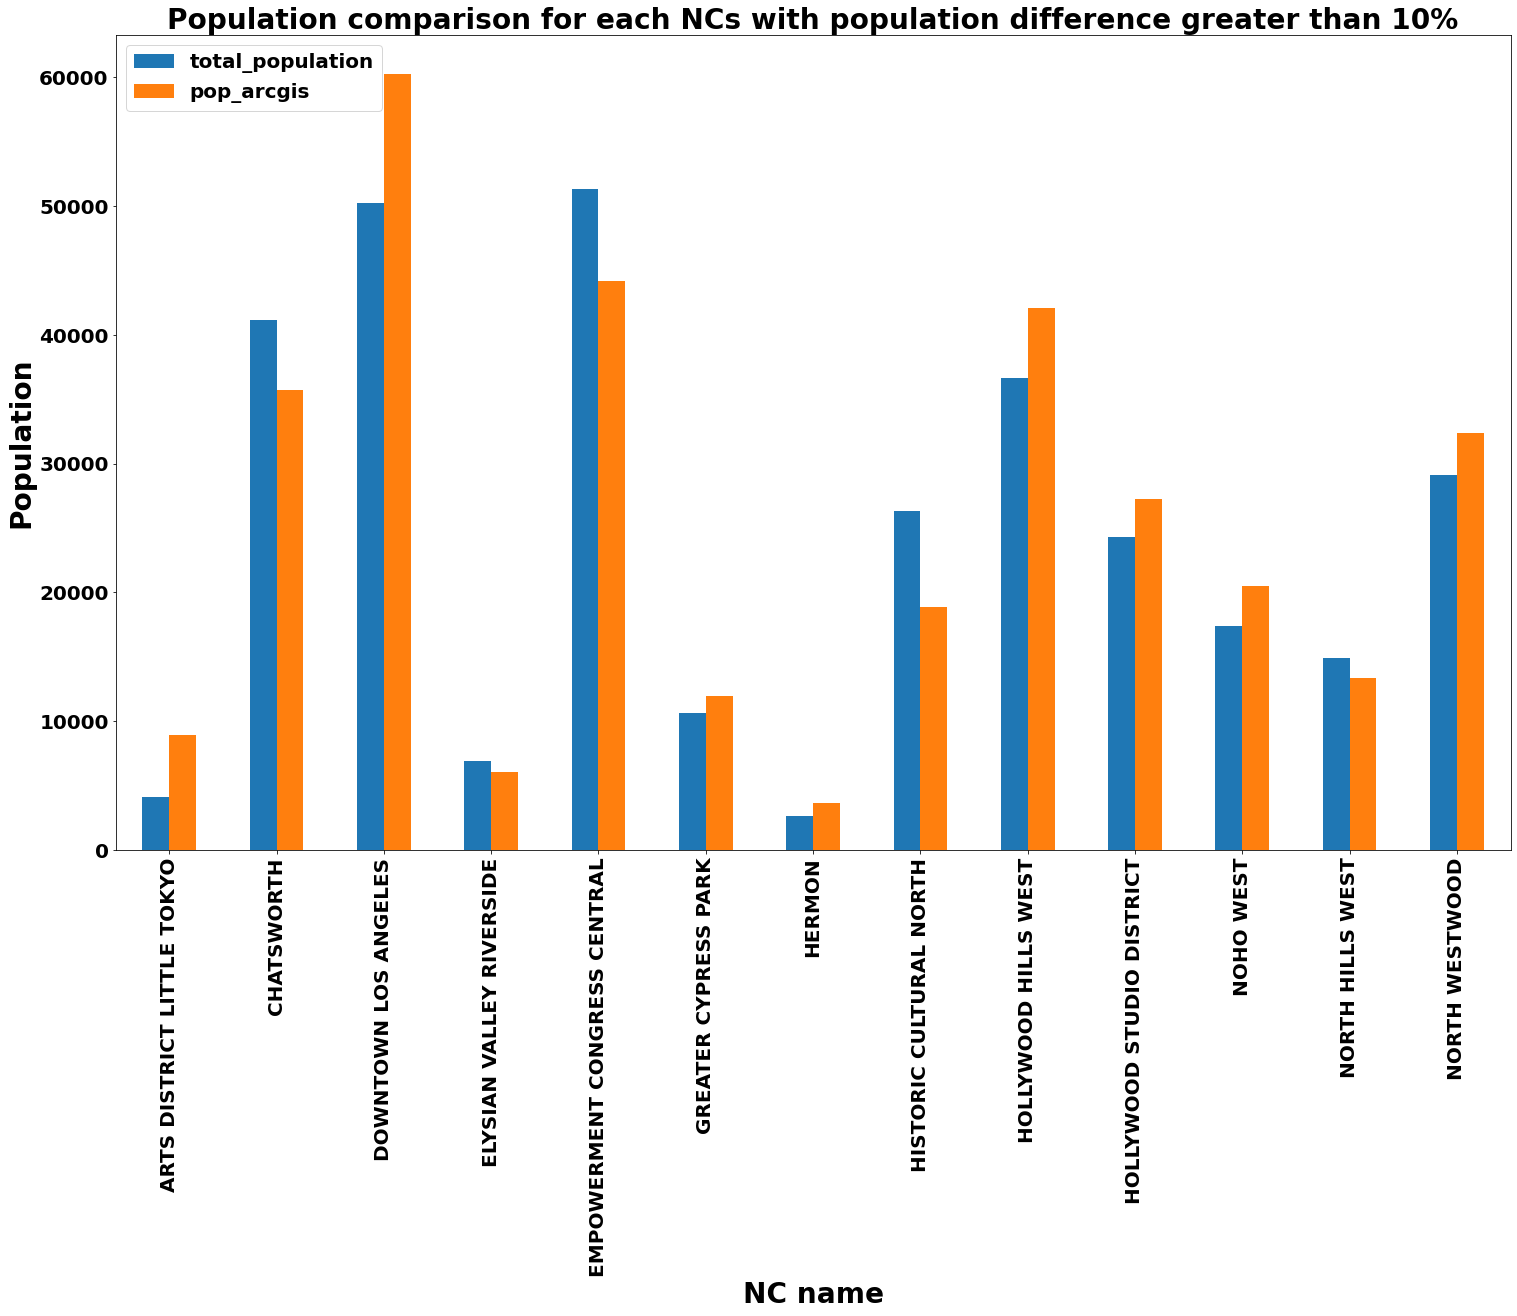

In [15]:
# Population difference greater than to 10%.
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
fig, ax = plt.subplots(figsize=(25, 15))
ax = plt.gca()
pop_diff_gt_10_perc.plot(
    kind="bar", x="NAME", y=["total_population", "pop_arcgis"], ax=ax
)
plt.title(
    "Population comparison for each NCs with population difference greater than 10%",
    size=28,
    fontweight="bold",
)
plt.xlabel("NC name", size=28)
plt.ylabel("Population", size=28)
ax.tick_params(axis="both", labelsize=20)
ax.legend(loc="upper left", fontsize=20)
plt.show()

In [16]:
# Comparing the area.
pop_compare["area_diff_percent"] = (
    abs(pop_compare["area"] - pop_compare["area_arcgis"])
    / ((pop_compare["area"] + pop_compare["area_arcgis"]) / 2)
) * 100
area_diff = pop_compare[["NAME", "NC_ID", "area", "area_arcgis", "area_diff_percent"]]

In [17]:
# Number of rows with difference in area lesser than or equal to 0.5 square miles.
area_diff[area_diff["area_diff_percent"] <= 0.5].nunique()

NAME                 79
NC_ID                79
area                 79
area_arcgis          79
area_diff_percent    79
dtype: int64

In [18]:
# Number of rows with difference in area greater than to 0.5 square miles.
area_diff[area_diff["area_diff_percent"] > 0.5].nunique()

NAME                 20
NC_ID                20
area                 20
area_arcgis          20
area_diff_percent    20
dtype: int64

In [19]:
# Adding the population density difference column.
pop_compare["pop_density_diff"] = (
    abs(pop_compare["pop_density"] - pop_compare["pop_den_arcgis"])
    / ((pop_compare["pop_density"] + pop_compare["pop_den_arcgis"]) / 2)
) * 100
pop_density_diff = pop_compare[
    ["NAME", "NC_ID", "pop_density", "pop_den_arcgis", "pop_density_diff"]
]

In [20]:
# Population difference greater than 10%.
pop_density_diff_gt_10_perc = pop_density_diff[
    pop_density_diff["pop_density_diff"] > 10
]

# Population difference lesser than or eqaul to 10%.
pop_density_diff_lte_10_perc = pop_density_diff[
    pop_density_diff["pop_density_diff"] <= 10
]

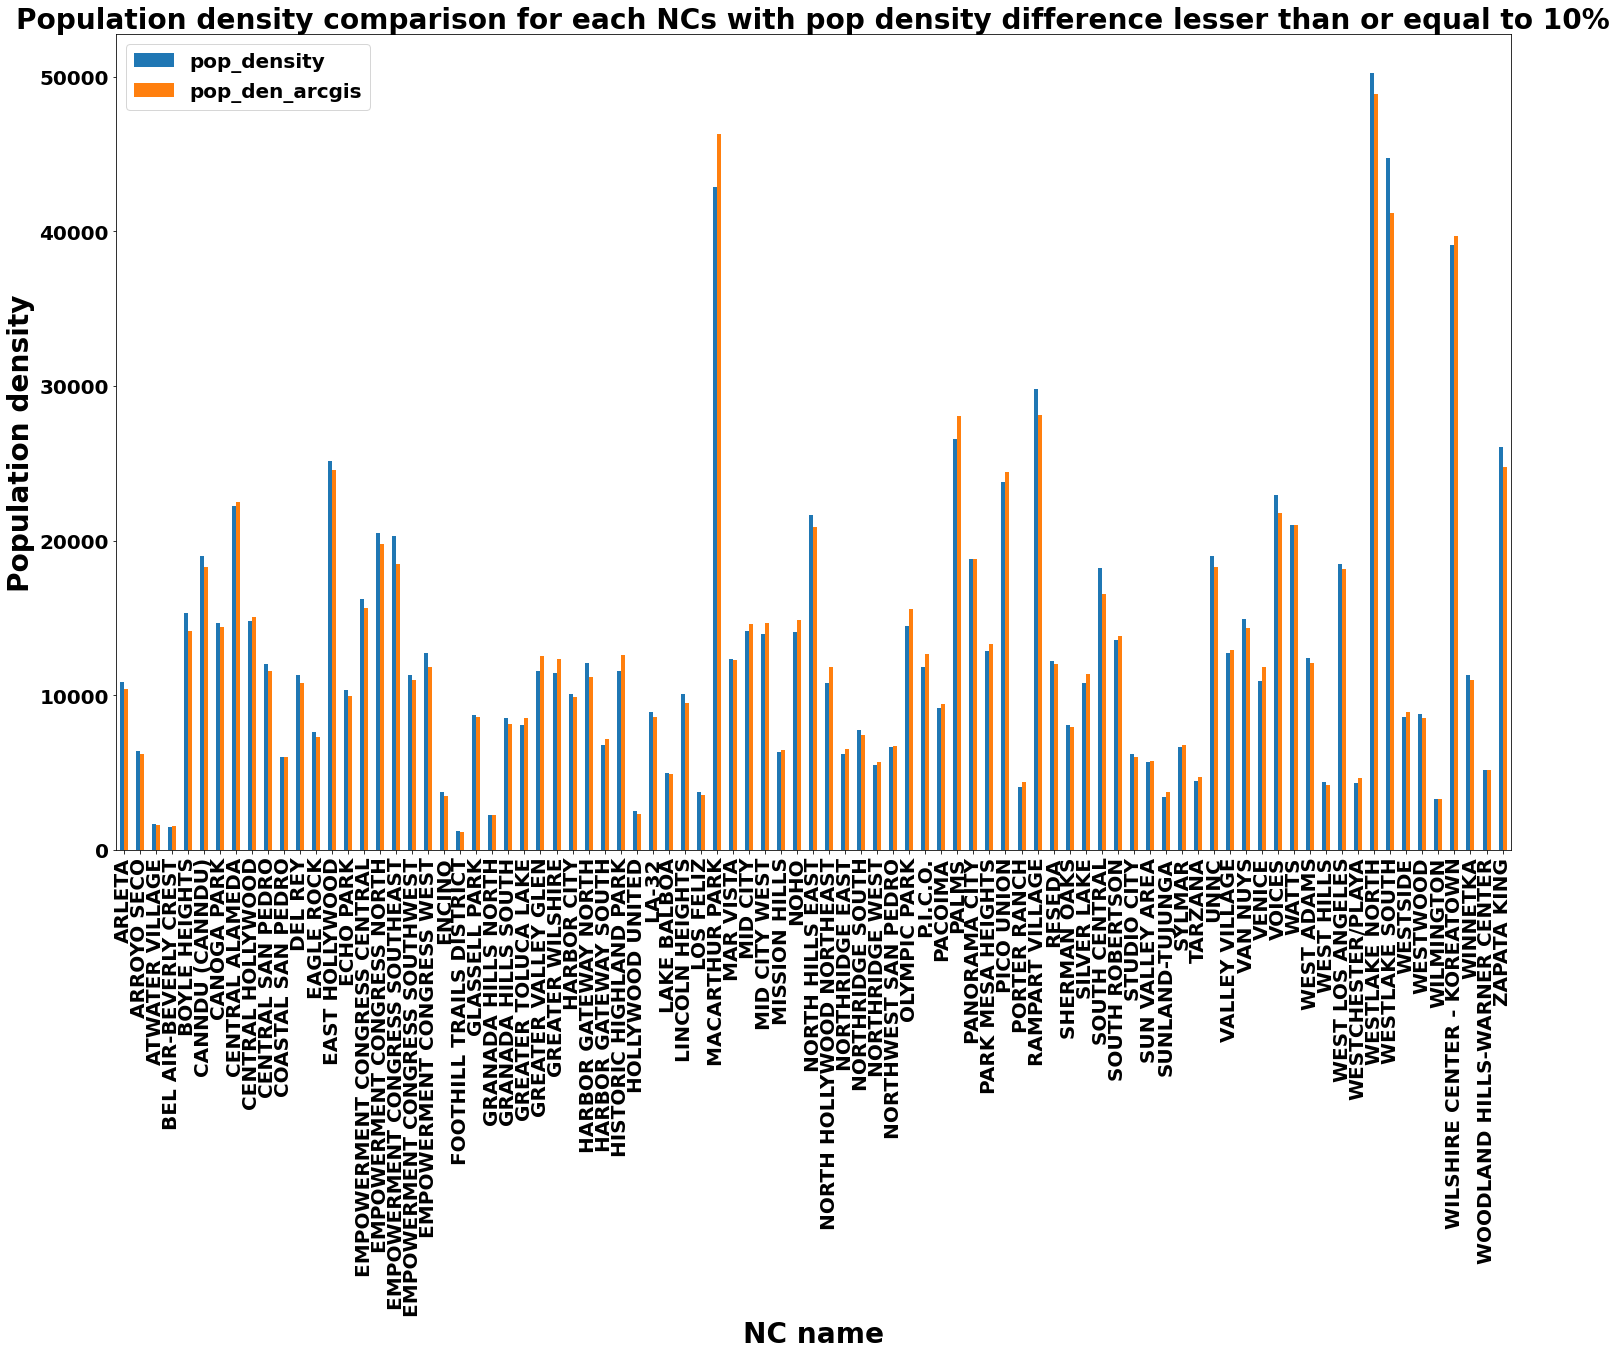

In [21]:
# Population density difference lesser than or equal to 10%
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
fig, ax = plt.subplots(figsize=(25, 15))
ax = plt.gca()
pop_density_diff_lte_10_perc.plot(
    kind="bar", x="NAME", y=["pop_density", "pop_den_arcgis"], ax=ax
)
plt.title(
    "Population density comparison for each NCs with pop density difference lesser than or equal to 10%",
    size=28,
    fontweight="bold",
)
plt.xlabel("NC name", size=28)
plt.ylabel("Population density", size=28)
ax.tick_params(axis="both", labelsize=20)
ax.legend(loc="upper left", fontsize=20)
plt.show()

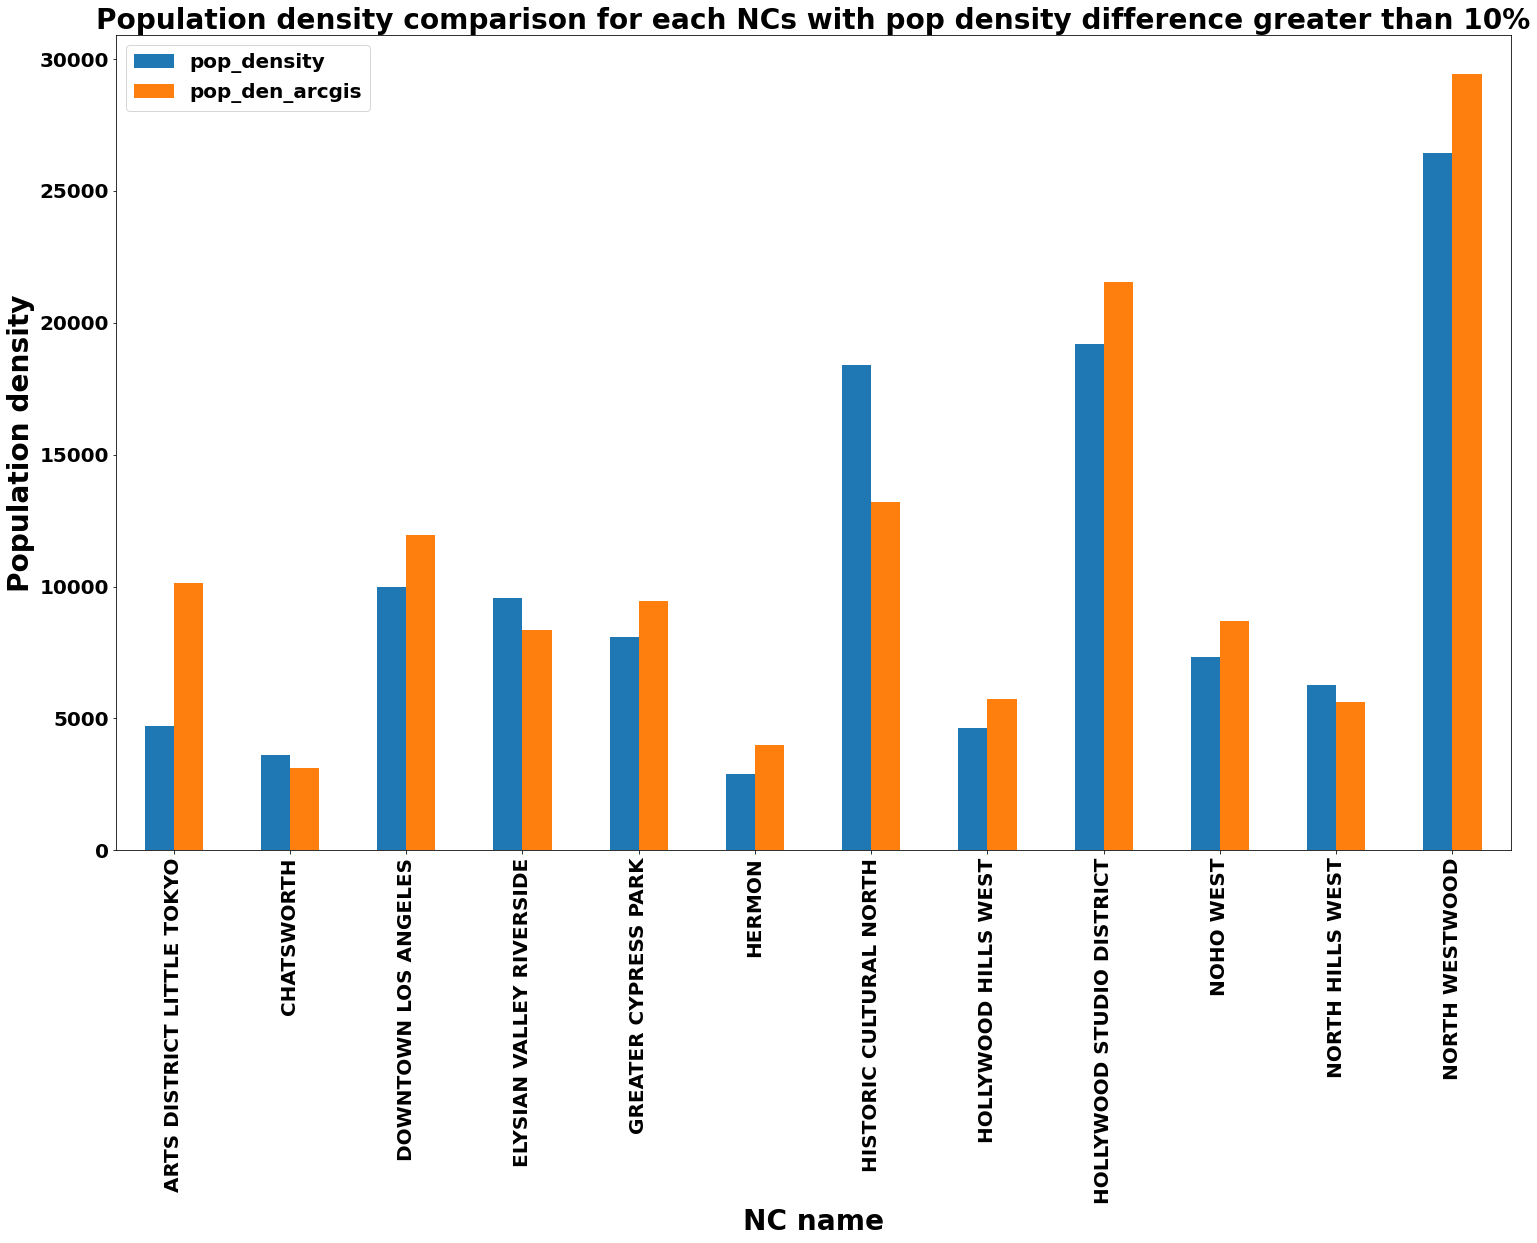

In [22]:
# Population density difference greater than 10%
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
fig, ax = plt.subplots(figsize=(25, 15))
ax = plt.gca()
pop_density_diff_gt_10_perc.plot(
    kind="bar", x="NAME", y=["pop_density", "pop_den_arcgis"], ax=ax
)
plt.title(
    "Population density comparison for each NCs with pop density difference greater than 10%",
    size=28,
    fontweight="bold",
)
plt.xlabel("NC name", size=28)
plt.ylabel("Population density", size=28)
ax.tick_params(axis="both", labelsize=20)
ax.legend(loc="upper left", fontsize=20)
plt.show()

In [23]:
# Saving the pop_compare dataframe. 
pop_compare.to_csv("pop_compare.csv")

In [24]:
# Summing up the total population. 
pop_total = pop_compare.total_population.sum()
pop_total_arcgis = pop_compare.pop_arcgis.sum()

In [25]:
pop_total

3825667

In [26]:
pop_total_arcgis

3814700.0